# Experiments with tag `leios-2025w09`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
})

## Read results

### IB production

In [2]:
ibs <- mongo(url="mongodb://thelio", db="leios2025w09a", collection="ibs")$find() %>% data.table
ibs <- ibs[order(`simulator`, `time_s`)]
ibs[, `size_bytes`:=as.numeric(`size_bytes`)]
ibs[, `simulator`:=factor(`simulator`)]
ibs %>% summary

      ib               scenario        simulator       size_bytes    
 Length:65620       Min.   :  0.05   haskell:32852   Min.   :102704  
 Class :character   1st Qu.: 30.00   rust   :32768   1st Qu.:102704  
 Mode  :character   Median : 50.00                   Median :102704  
                    Mean   : 62.86                   Mean   :102704  
                    3rd Qu.:100.00                   3rd Qu.:102704  
                    Max.   :100.00                   Max.   :102704  
                                                     NA's   :32768   
     time_s      
 Min.   :  0.13  
 1st Qu.: 38.13  
 Median : 75.13  
 Mean   : 75.22  
 3rd Qu.:113.13  
 Max.   :150.00  
                 

### Elapsed time for receipt of IBs

In [3]:
ibsElapsed <- mongo(url="mongodb://thelio", db="leios2025w09a", collection="ibsElapsed")$find() %>% data.table
ibsElapsed <- ibsElapsed[order(`simulator`, `scenario`, `time_s`)]
ibsElapsed[, `simulator`:=factor(`simulator`)]
ibsElapsed %>% summary

   elapsed_s             ib                node              scenario     
 Min.   :  0.1055   Length:3836080     Length:3836080     Min.   :  0.05  
 1st Qu.:  1.6151   Class :character   Class :character   1st Qu.: 20.00  
 Median :  2.5678   Mode  :character   Mode  :character   Median : 50.00  
 Mean   :  8.5969                                         Mean   : 48.32  
 3rd Qu.:  6.1812                                         3rd Qu.:100.00  
 Max.   :141.5641                                         Max.   :100.00  
   simulator           time_s        
 haskell:2605798   Min.   :  0.2355  
 rust   :1230282   1st Qu.: 38.7501  
                   Median : 76.2029  
                   Mean   : 76.1667  
                   3rd Qu.:113.5069  
                   Max.   :150.0000  

## Diagnostics

### Check that the IB production rate is close to expectations

In [4]:
ibs[, .(`Actual IBs`=.N, `Duration`=max(`time_s`)), by=.(`simulator`, `scenario`)][, .(`simulator`, `scenario`, `Actual IBs`, `Expected IBs`=`Duration`*`scenario`)][order(`simulator`, `scenario`)]

simulator,scenario,Actual IBs,Expected IBs
<fct>,<dbl>,<int>,<dbl>
haskell,5e-02,3,5.1065
haskell,1e-01,12,14.6130
haskell,2e-01,28,29.4260
haskell,3e-01,42,44.1390
haskell,5e-01,67,74.0650
haskell,1e+00,140,149.1300
haskell,2e+00,319,298.2600
haskell,3e+00,474,447.3900
haskell,5e+00,746,745.6500


### Check the linearity and slope of cumulative IB production

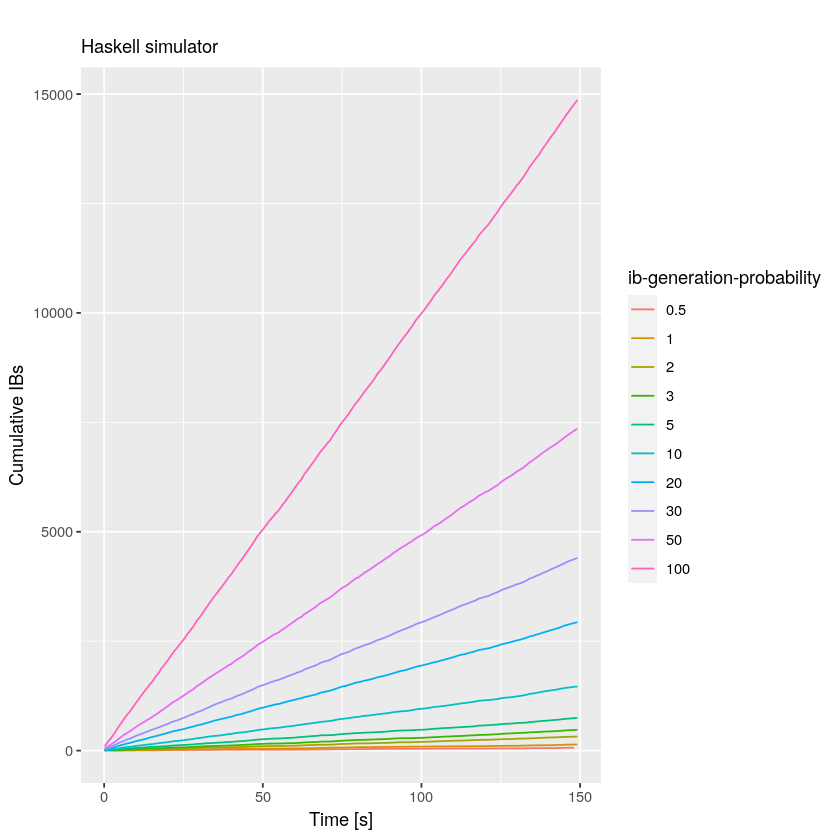

In [5]:
ggplot(
    ibs[`simulator` == "haskell" & `scenario` >= 0.5, .(`IBs`=.N), by=.(`ib-generation-probability`=factor(`scenario`), `time_s`)][, .(`time_s`, `Cumulative IBs`=cumsum(`IBs`)), by=.(`ib-generation-probability`)],
    aes(x=`time_s`, y=`Cumulative IBs`, color=`ib-generation-probability`)
) +
  geom_line() +
  xlab("Time [s]") +
  ggtitle("", subtitle="Haskell simulator")

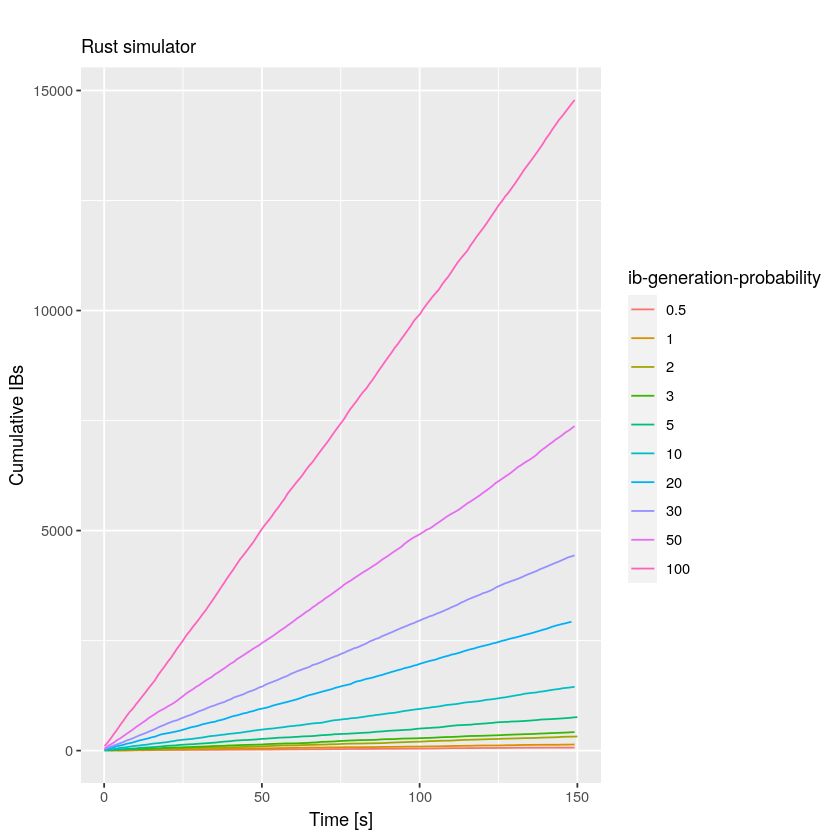

In [6]:
ggplot(
    ibs[`simulator` == "rust" & `scenario` >= 0.5, .(`IBs`=.N), by=.(`ib-generation-probability`=factor(`scenario`), `time_s`)][, .(`time_s`, `Cumulative IBs`=cumsum(`IBs`)), by=.(`ib-generation-probability`)],
    aes(x=`time_s`, y=`Cumulative IBs`, color=`ib-generation-probability`)
) +
  geom_line() +
  xlab("Time [s]") +
  ggtitle("", subtitle="Rust simulator")

### Examine the spread in elapsed times as the IB generation rate increases

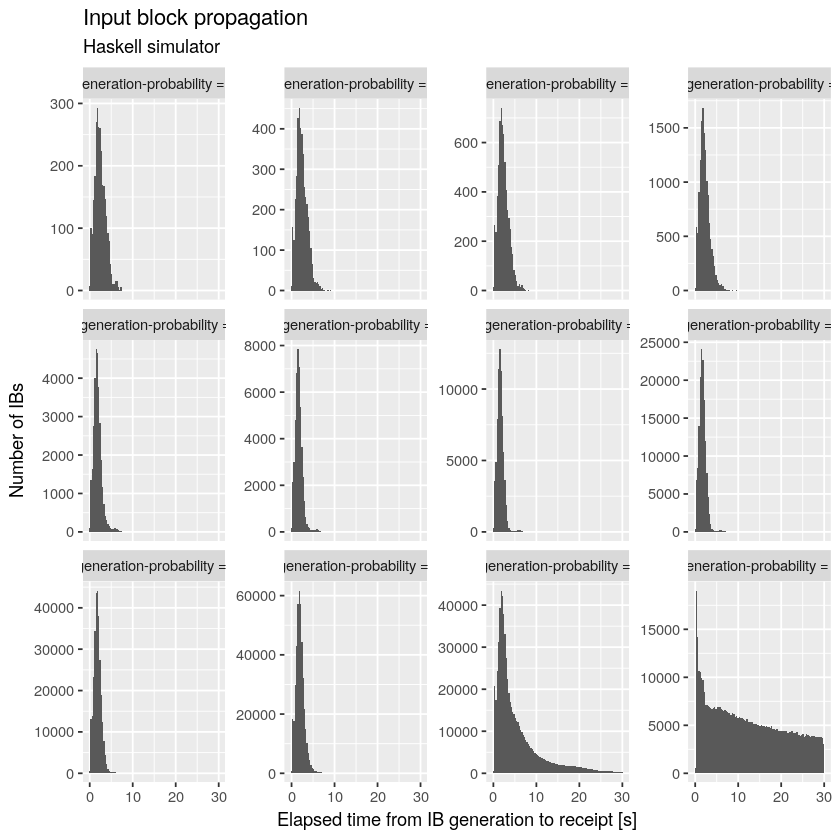

In [7]:
ggplot(ibsElapsed[`simulator` == "haskell" & `scenario` >= 0.2 & `elapsed_s` <= 30, .(
    `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
    `elapsed_s`
)], aes(x=`elapsed_s`)) +
  geom_histogram(bins=100) +
  facet_wrap(. ~ `scenario`, scales="free_y") +
  xlab("Elapsed time from IB generation to receipt [s]") +
  ylab("Number of IBs") +
  ggtitle("Input block propagation", subtitle="Haskell simulator")

In [8]:
ggsave("ibelapsed-histogram-hs.png", width=8, height=6, units="in", dpi=150)

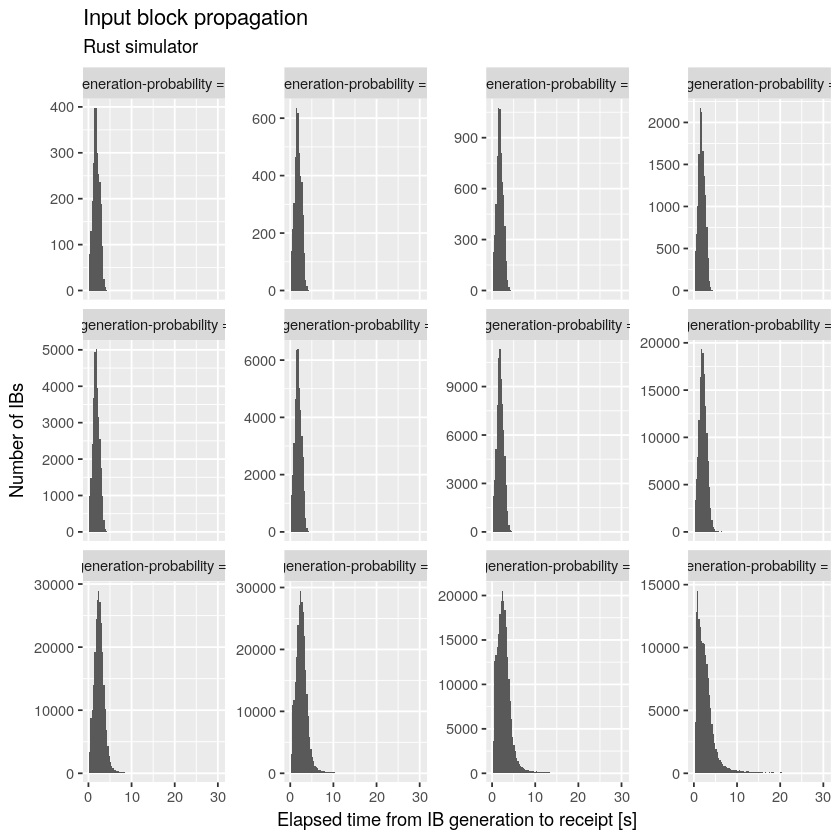

In [9]:
ggplot(ibsElapsed[`simulator` == "rust" & `scenario` >= 0.2 & `elapsed_s` <= 30, .(
    `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
    `elapsed_s`
)], aes(x=`elapsed_s`)) +
  geom_histogram(bins=100) +
  facet_wrap(. ~ `scenario`, scales="free_y") +
  xlab("Elapsed time from IB generation to receipt [s]") +
  ylab("Number of IBs") +
  ggtitle("Input block propagation", subtitle="Rust simulator")

In [10]:
ggsave("ibelapsed-histogram-rs.png", width=8, height=6, units="in", dpi=150)

## Fraction of IBs received by end of simulation

In [11]:
ibsPerformance <- ibsElapsed[`scenario` >= 5, .(
    `time_s`,
    `Received IBs`=as.numeric(.N)
), by=.(`simulator`, `scenario`, `ib`)][, .(
    `Sent IBs`=as.numeric(.N),
    `Received IBs`=sum(`Received IBs`)
), by=.(`simulator`, `scenario`, `time_s`)][, .(
    `Received [%]`=100*sum(`Received IBs`)/sum(`Sent IBs`)/99
), by=.(`simulator`, `scenario`,`time_s`)]

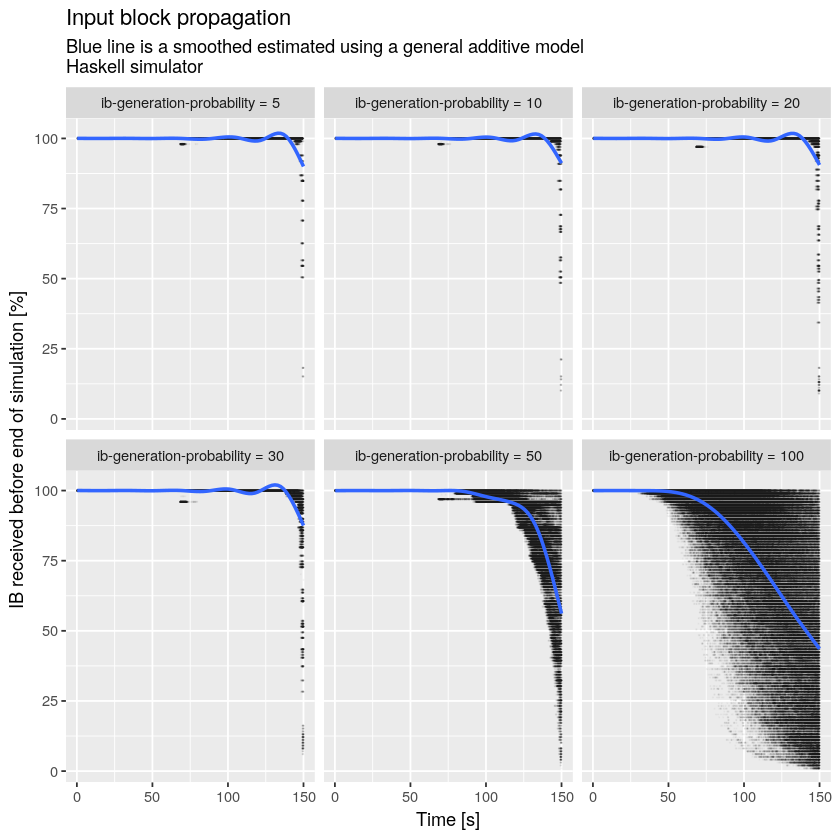

In [12]:
ggplot(
    ibsPerformance[`simulator` == "haskell", .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received before end of simulation [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model\nHaskell simulator")

In [13]:
ggsave("ibperformance-end-hs.png", width=8, height=6, units="in", dpi=150)

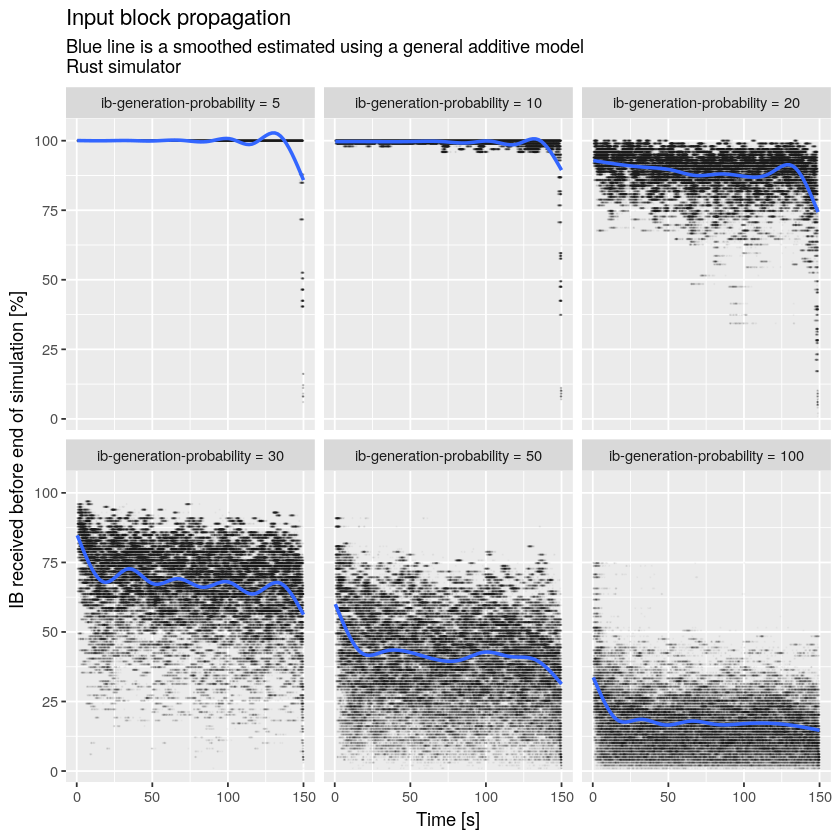

In [14]:
ggplot(
    ibsPerformance[`simulator` == "rust", .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received before end of simulation [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model\nRust simulator")

In [15]:
ggsave("ibperformance-end-rs.png", width=8, height=6, units="in", dpi=150)

## Fraction of IBs received within five seconds

In [16]:
ibsPerformance <- ibsElapsed[`scenario` >= 5 &`elapsed_s` <= 5, .(
    `time_s`,
    `Received IBs`=as.numeric(.N)
), by=.(`simulator`, `scenario`, `ib`)][, .(
    `Sent IBs`=as.numeric(.N),
    `Received IBs`=sum(`Received IBs`)
), by=.(`simulator`, `scenario`, `time_s`)][, .(
    `Received [%]`=100*sum(`Received IBs`)/sum(`Sent IBs`)/99
), by=.(`simulator`, `scenario`,`time_s`)]

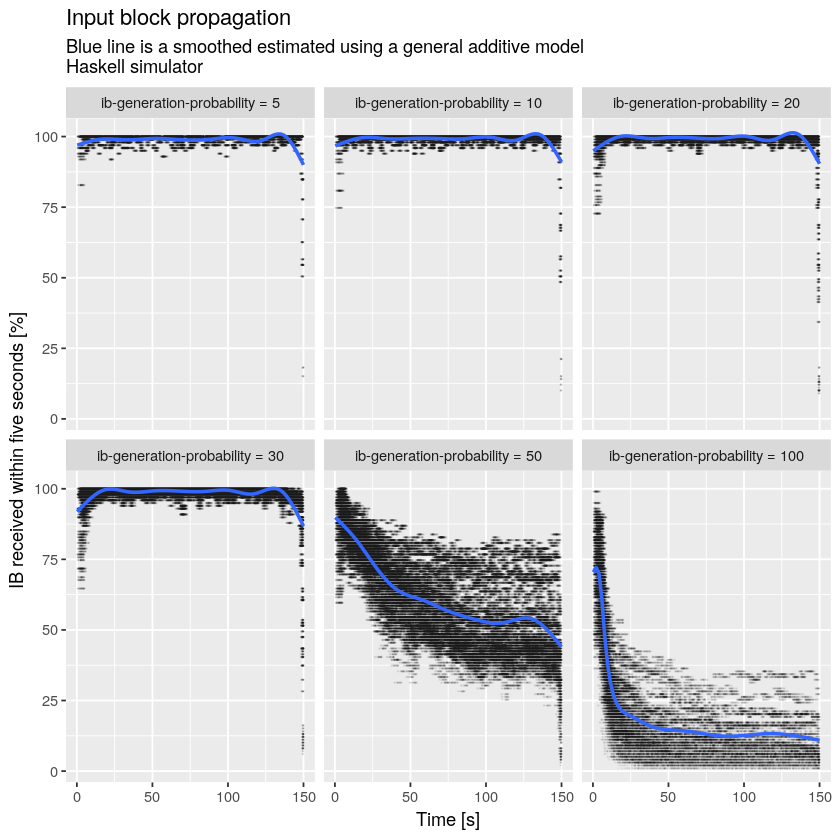

In [17]:
ggplot(
    ibsPerformance[`simulator` == "haskell", .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received within five seconds [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model\nHaskell simulator")

In [18]:
ggsave("ibperformance-5s-hs.png", width=8, height=6, units="in", dpi=150)

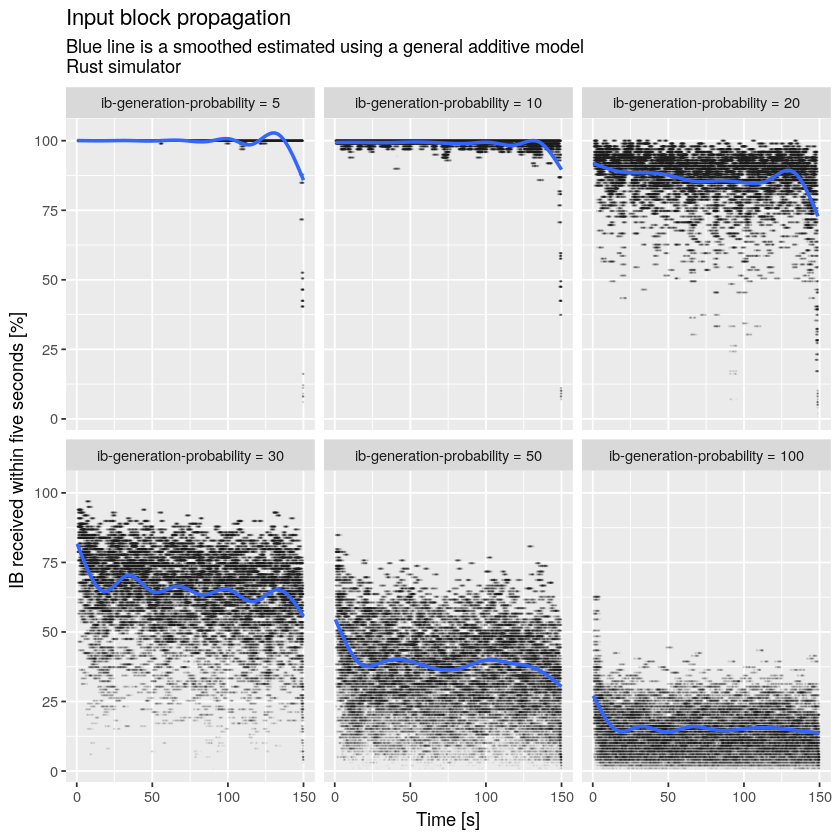

In [19]:
ggplot(
    ibsPerformance[`simulator` == "rust", .(
        `scenario`=factor(paste("ib-generation-probability =", `scenario`), levels=paste("ib-generation-probability =", ibsElapsed[, unique(`scenario`)])),
        `time_s`, 
        `Received [%]`
    )], 
    aes(x=`time_s`, y=`Received [%]`)
) +
  geom_point(size=0.05, alpha=0.02) +
  geom_smooth(formula=y ~ s(x, bs = "cs"), method="gam") +
  facet_wrap(. ~ `scenario`) +
  xlab("Time [s]") +
  ylab("IB received within five seconds [%]") +
  ggtitle("Input block propagation", subtitle="Blue line is a smoothed estimated using a general additive model\nRust simulator")

In [20]:
ggsave("ibperformance-5s-rs.png", width=8, height=6, units="in", dpi=150)